In [1]:
import numpy as np
import astropy.units as u
import yaml
from astropy.constants import G
import os.path
import sys
from argparse import ArgumentParser
import pathlib
from mwlmc import model as mwlmc_model
Model = mwlmc_model.MWLMC()

from scipy.spatial.transform import Rotation
import scipy
import gala.integrate as gi
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic
import yaml
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"
plt.style.use('my_standard.mplstyle')

Initialising MW ... 
sphcoefs::read_coef_file: reading coefficients from file . . . success!!
Initialising LMC ... 
sphcoefs::read_coef_file: reading coefficients from file . . . success!!
Initialising MW disc ... 
cylcoefs::read_simple_coef_file: reading coefficients from file . . . success!!


sphcache::read_sph_cache: trying to read cached table . . . success!!
sphcache::read_sph_cache: trying to read cached table . . . success!!
cylcache::read_cyl_cache: trying to read cached table . . . success!!


In [2]:
# # Milky Way halo
# _, MWHcoeffs = Model.return_mw_coefficients()
# MWHcoeffs = np.array(MWHcoeffs)
# MWHcoeffs[:,0] = MWHcoeffs[:,0][0] 
# MWHcoeffs[:,1:] = MWHcoeffs[:,1:]*0
# Model.install_mw_coefficients(MWHcoeffs)

# # Milky Way disc
# MWDfloats, MWDctmp, MWDstmp = Model.return_disc_coefficients()
# MWDctmp, MWDstmp = np.array(MWDctmp), np.array(MWDstmp)
# MWDctmp[:,0], MWDstmp[:,0] = MWDctmp[:,0][0], MWDstmp[:,0][0] # Turn this on to get rigid monopole disc 
# # MWDctmp[:,0], MWDstmp[:,0] = MWDctmp[:,0][0]*0, MWDstmp[:,0][0]*0 # Turn this on to get rid of disc altogether
# MWDctmp[:,1:], MWDstmp[:,1:] = MWDctmp[:,1:]*0, MWDstmp[:,1:]*0
# Model.install_disc_coefficients(MWDctmp,MWDstmp)

# # LMC halo
# _, LMCcoeffs = Model.return_lmc_coefficients()
# LMCcoeffs = np.array(LMCcoeffs)
# LMCcoeffs *= 0 
# Model.install_lmc_coefficients(LMCcoeffs)


In [66]:
# MiyamotoNagai = gp.MiyamotoNagaiPotential(6.8e10*u.Msun, 3*u.kpc, 0.28*u.kpc, units=galactic)

In [2]:
def gala_F_inertial(t, w, mwdflag, mwhflag, lmcflag):
    t = t / 1e3  # Myr -> Gyr
    x0 = np.array(Model.expansion_centres(t))
    # disk
    # acc_disk = Model.mwd_fields(t, *(w[:3, :] - x0[:3, None]), mwdharmonicflag=mwdflag)[:, :3]
    MiyamotoNagai = gp.MiyamotoNagaiPotential(6.8e10*u.Msun, 3*u.kpc, 0.28*u.kpc, units=galactic, origin=x0[:3])
    acc_disk = MiyamotoNagai.acceleration(w[:3, :] - x0[:3, None]).to((u.km**2/(u.s**2*u.kpc))).value
    # halo
    acc_halo = Model.mwhalo_fields(t, *(w[:3] - x0[3:6, None]), mwhharmonicflag=mwhflag)[:, :3]
    # lmc
    acc_lmc = Model.lmc_fields(t, *(w[:3] - x0[6:9, None]), lmcharmonicflag=lmcflag)[:, :3]
    
    accs = (acc_disk.T + acc_halo + acc_lmc) * (u.km**2/(u.s**2*u.kpc))
    accs = accs.decompose(galactic).value
    return np.vstack((w[3:], accs.T))

def gala_rewind_inertial(Tbegin, Tend, dt, w, mwdflag, mwhflag, lmcflag):
    
    integrator = gi.LeapfrogIntegrator(gala_F_inertial, func_units=galactic, func_args=(mwdflag, mwhflag, lmcflag,))
 
    mwd_x0 = np.array(Model.expansion_centres(0.)[:3])*u.kpc 
    mwd_v0 = np.array(Model.expansion_centre_velocities(0.)[:3])*(u.km/u.s) 
    w0 = gd.PhaseSpacePosition(pos=w.xyz + mwd_x0,
                               vel=(w.v_xyz.to(u.km/u.s) + mwd_v0).to(u.kpc/u.Myr) )
    orbit = integrator.run(w0, dt=-dt*u.Myr, t1=Tend*u.Gyr, t2=Tbegin*u.Gyr)

    disk_x0 = np.array([Model.expansion_centres(t)[:3] for t in orbit.t.to_value(u.Gyr)]) 
    disk_v0 = np.array([Model.expansion_centre_velocities(t)[:3] for t in orbit.t.to_value(u.Gyr)]) 
    pos=orbit.xyz - disk_x0.T*u.kpc,
    vel=orbit.v_xyz.to(u.km/u.s) - disk_v0.T*u.km/u.s,
    t=orbit.t
    return pos[0].to(u.kpc), vel[0].to(u.km/u.s), t.to(u.Gyr)

In [3]:
def gala_rewind_inertial_novelcor(Tbegin, Tend, dt, w, mwdflag, mwhflag, lmcflag):
    
    integrator = gi.LeapfrogIntegrator(gala_F_inertial, func_units=galactic, func_args=(mwdflag, mwhflag, lmcflag,))
 
    mwd_x0 = np.array(Model.expansion_centres(0.)[:3])*u.kpc 
    mwd_v0 = np.array(Model.expansion_centre_velocities(0.)[:3])*(u.km/u.s) * 0
    w0 = gd.PhaseSpacePosition(pos=w.xyz + mwd_x0,
                               vel=(w.v_xyz.to(u.km/u.s) + mwd_v0).to(u.kpc/u.Myr) )
    orbit = integrator.run(w0, dt=-dt*u.Myr, t1=Tend*u.Gyr, t2=Tbegin*u.Gyr)

    disk_x0 = np.array([Model.expansion_centres(t)[:3] for t in orbit.t.to_value(u.Gyr)]) 
    disk_v0 = np.array([Model.expansion_centre_velocities(t)[:3] for t in orbit.t.to_value(u.Gyr)]) 
    pos=orbit.xyz - disk_x0.T*u.kpc,
    vel=orbit.v_xyz.to(u.km/u.s) - disk_v0.T*u.km/u.s,
    t=orbit.t
    return pos[0].to(u.kpc), vel[0].to(u.km/u.s), t.to(u.Gyr)

In [4]:
def gala_F_noninertial(t, w, mwdflag, mwhflag, lmcflag):
    t = t / 1e3  # Myr -> Gyr
    x0 = np.array(Model.expansion_centres(t))
    accs = Model.all_forces(t, *(w[:3, :]), mwhflag, mwdflag, lmcflag) * (u.km**2/(u.s**2*u.kpc))
    
    accs = (accs).decompose(galactic).value
    return np.vstack((w[3:], accs.T))

def gala_rewind_noninertial(Tbegin, Tend, dt, w, mwdflag, mwhflag, lmcflag):
    
    integrator = gi.LeapfrogIntegrator(gala_F_noninertial, func_units=galactic, func_args=(mwdflag, mwhflag, lmcflag,))
 
    w0 = gd.PhaseSpacePosition(pos=w.xyz ,
                               vel=(w.v_xyz.to(u.km/u.s)).to(u.kpc/u.Myr) )
    orbit = integrator.run(w0, dt=-dt*u.Myr, t1=Tend*u.Gyr, t2=Tbegin*u.Gyr)

    pos=orbit.xyz 
    vel=orbit.v_xyz.to(u.km/u.s) 
    t=orbit.t
    return pos.to(u.kpc), vel.to(u.km/u.s), t.to(u.Gyr)

In [9]:
def readparams(paramfile):
    """
    Read in the stream model parameters
    """
    with open(paramfile) as f:
        d = yaml.safe_load(f)

    prog_ics = np.array(d["prog_ics"])
    prog_mass = d["prog_mass"]
    prog_scale = d["prog_scale"] # kpc
    Tbegin = d["Tbegin"]
    Tfinal =  d["Tfinal"]
    dtmin  = 0.002 #d["dtmin"]
    haloflag = d["haloflag"]
    lmcflag = d["lmcflag"]
    discflag = d["discflag"]

    return [prog_ics, Tbegin, Tfinal, dtmin, haloflag, discflag, lmcflag ]

In [10]:
file = "../ics/full-mwh-full-mwd-full-lmc/param_4.yaml"
# file = "../ics/param-files/gd1/static-mw.yaml"
params = readparams(file)
fc, Tbegin, Tfinal, dtmin, haloflag, discflag, lmcflag  = params

print(fc, Tbegin, Tfinal, dtmin, haloflag, discflag, lmcflag )

[ 2.65342590e-01 -1.85704472e+01  7.71772156e+00  1.15912141e-01
 -2.86033975e-03  4.53354278e-02] -5.0 0.0 0.002 63 63 63


In [11]:
w0 = gd.PhaseSpacePosition.from_w(fc.T, units=galactic)

prog_orbit_inertial = gala_rewind_inertial(Tbegin, Tfinal, dtmin*u.Gyr.to(u.Myr), w0, discflag, haloflag, lmcflag)

prog_orbit_inertial_novelcorr = gala_rewind_inertial_novelcor(Tbegin, Tfinal, dtmin*u.Gyr.to(u.Myr), w0, discflag, haloflag, lmcflag)

prog_orbit_noninertial = gala_rewind_noninertial(Tbegin, Tfinal, dtmin*u.Gyr.to(u.Myr), w0, discflag, haloflag, lmcflag)


Text(0, 0.5, '$\\mathbf{v}_{\\mathrm{prog}}$ [km/s]')

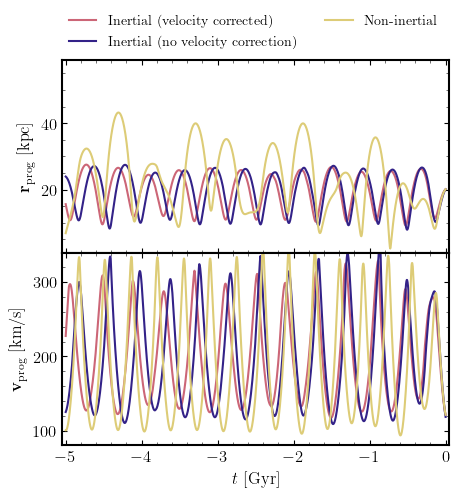

In [12]:
fig, ax = plt.subplots(2,1, figsize=(5,5), sharex='col')
plt.subplots_adjust(hspace=0.0)

plt.sca(ax[0])
plt.plot(prog_orbit_inertial[2], np.linalg.norm(prog_orbit_inertial[0].T,axis=1).value, label='Inertial (velocity corrected)')
plt.plot(prog_orbit_inertial_novelcorr[2], np.linalg.norm(prog_orbit_inertial_novelcorr[0].T,axis=1).value, label='Inertial (no velocity correction)')
plt.plot(prog_orbit_noninertial[2], np.linalg.norm(prog_orbit_noninertial[0].T,axis=1).value, label='Non-inertial')
plt.xlim(-5.05,0.05)
plt.ylim(1,59)

plt.legend(ncol=2, frameon=False, fontsize=10,  bbox_to_anchor=(1., 1.3))
plt.ylabel('$\mathbf{r}_{\mathrm{prog}}$ [kpc]')

plt.sca(ax[1])
plt.plot(prog_orbit_inertial[2], np.linalg.norm(prog_orbit_inertial[1].T,axis=1).value )
plt.plot(prog_orbit_inertial_novelcorr[2], np.linalg.norm(prog_orbit_inertial_novelcorr[1].T,axis=1).value )
plt.plot(prog_orbit_noninertial[2], np.linalg.norm(prog_orbit_noninertial[1].T,axis=1).value)
plt.ylim(81, 339)

plt.xlabel('$t$ [Gyr]')
plt.ylabel('$\mathbf{v}_{\mathrm{prog}}$ [km/s]')

# plt.savefig('figures/fictitious-forces')